In [1]:
from astropy.table import Table
import numpy as np
lens_samples = Table.read('lens_samples.fits')
mask_stack = lens_samples['if_obs_stack'].data
mask_single = lens_samples['if_obs_single'].data
stack_samples = lens_samples[mask_stack]
single_samples = lens_samples[mask_single]
stack_samples.sort('SNR_stack')
single_samples.sort('SNR_stack')
print(np.count_nonzero(mask_stack), np.count_nonzero(mask_single))

2852 1305


In [16]:
stack_samples[0:5]

thetaE_s0,mass_s0,z_s0,re_s0,q_s0,pa_s0,x_s0,y_s0,mag_g_s0,mag_r_s0,mag_i_s0,mag_z_s0,vdisp_l,re_l,q_l,z_l,mag_g_l,mag_r_l,mag_i_l,mag_z_l,SNR_g,SNR_r,SNR_i,SNR_z,SNR_stack,best_band,mu,if_ring,if_obs_stack,if_obs_single,noise_seed
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,bool,bool,bool,int64
2.10850073219709,957902267208.1566,1.2919,0.19443134684984806,0.8961069023351139,107.49952291081047,-0.469021521572059,1.4740127207623872,25.4435,25.257,24.9597,24.5325,343.6230693609952,1.3485565847221497,0.6754008329847273,0.3872798046965413,19.276016566811627,17.319575016507706,16.61958021467007,16.186686221527633,9.992230120314437,9.709454043996564,10.442833811567786,9.900631300498864,20.004294890550696,i,3.1666517089987507,False,True,False,370
0.6357653829084472,71820475181.33592,1.1002,0.245246065895914,0.7732117545406834,104.66808130887044,-0.09044122019105877,0.32643120551261356,25.865,25.2444,24.7962,24.1073,184.00516206309752,0.4491307670406152,0.6597435609645665,0.31118379673354557,21.433985099499136,19.59905396449873,18.96114443440696,18.620500153026157,6.958251767433093,9.082155915377724,10.948354432559528,13.273162676568372,20.006682955175265,z,4.5803587066263205,True,True,False,105
0.6060036865657127,112099445425.3973,2.1141,0.11720352637022632,0.7477599576579679,56.544457081795144,-0.05141613711508308,-0.26150397447463153,26.0883,26.2076,26.1803,25.9271,192.30658229920374,0.5575297150612109,0.3262483173539915,0.6326339801819034,24.50364030590919,22.58124540213672,21.17331782853457,20.579522347218337,13.239251654675257,10.409957444356094,8.893626364986345,7.097797210491898,20.008850107888982,g,6.112155598087506,True,True,False,41
0.8480788139861849,127667248035.99792,2.3218,0.1966336290286775,0.43665187818024953,134.51597231517778,0.14620761203646648,-0.03882606390596261,25.8594,25.8912,25.9414,25.9783,199.57654855154604,0.6010247078493325,0.9535172021659588,0.3763402598105379,21.813243246079836,19.850526254646994,19.169932581449466,18.749235327870256,14.684998030074008,11.287858645118842,8.699225846790785,5.38817356046553,20.00891274072715,g,9.808403238070056,False,True,False,138
0.910945749366488,263375414402.31973,1.4943,0.15480755900053786,0.6224660757874401,127.57821580665205,0.037616526542951736,0.3247286424854468,26.3186,26.1932,25.6033,25.1191,246.84547640143415,0.7386000987273974,0.7254137101431054,0.564790851872999,22.6019259266246,20.759931062324302,19.493588682116908,18.937054955844896,9.019113826618177,8.508596040680935,11.408829910978698,11.115446154043843,20.011075860413854,i,7.0944960039089535,True,True,False,29


In [5]:
this_table = stack_samples[0]
this_table['thetaE_s0']

2.10850073219709

snr of arc is 18.581716237044205


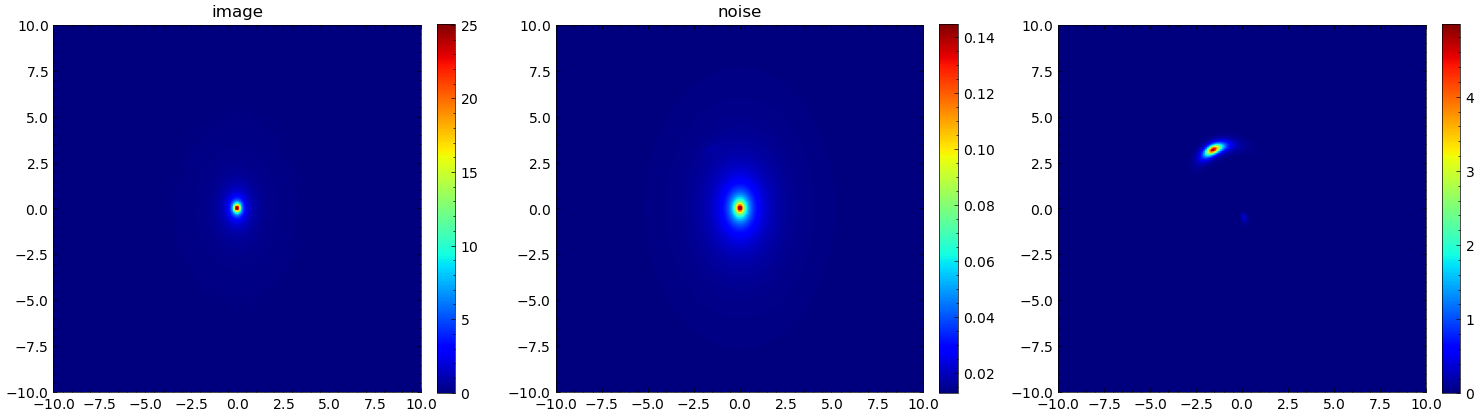

4.987229485857042


In [52]:
from SimCsstLens.SimLensImage import MassLightModel as MLM
from SimCsstLens.SimLensImage import Simulator
from SimCsstLens.SimLensImage import Util as SSU
from matplotlib import pyplot as plt

dpix = 0.1
zero_mag = 25.23
psf_kernel = SSU.gauss_psf(
    npix=None, 
    dpix=dpix, 
    sigma=None, 
    fwhm=0.18, 
    ree80=None, 
    nsub=4
)
skyback = SSU.sky_cps_from_mag(22.35, zero_mag, dpix) #sky background in unit of counts/s/pix

this_table = stack_samples[0]
this_lens_mass = [
    MLM.SieMass(
        xc=0.0, 
        yc=0.0, 
        q=this_table['q_l'], 
        PA=90.0, #manually requirment, consistent to the lenspop code, just used for code debugging 
        thetaE=this_table['thetaE_s0'],        
    ),
]

lens_vis_mag = (this_table['mag_r_l'] + this_table['mag_i_l'] + this_table['mag_z_l'])/3.0
this_lens_light = [
    MLM.SersicLight(        
        xc=0.0, 
        yc=0.0, 
        q=this_table['q_l'], 
        PA=90.0, #manually requirment, consistent to the lenspop code, just used for code debugging
        Re=this_table['re_l'], 
        Ie=None, 
        n=4.0,
        m=lens_vis_mag,
        mag_zero=zero_mag, #zero mag for e-/s
    ),
]

src_vis_mag = (this_table['mag_r_s0'] + this_table['mag_i_s0'] + this_table['mag_z_s0'])/3.0
this_source_light = [
    MLM.SersicLight(
        xc=this_table['x_s0'], 
        yc=this_table['y_s0'], 
        q=this_table['q_s0'], 
        PA=this_table['pa_s0'], 
        Re=this_table['re_s0'], 
        Ie=None, 
        n=1.0,
        m=src_vis_mag,
        mag_zero=zero_mag,    
    )
]
    
this_sim_obj = Simulator.SingleBandSimulator(
    lens_light_models=this_lens_light,
    lens_mass_models=this_lens_mass,
    source_light_models=this_source_light,
)

this_sim_obj.generate_ideal_image(npix=200, dpix=dpix, nsub=2)


this_sim_obj.overlay_instrument_effect(
    psf=psf_kernel, #a 2d psf kernel image
    skylevel=skyback, #unit: counts/s/pix
    dark_current=0, #unit: counts/s/pix
    readout_noise=4.5, #unit: counts/pix
    n_exposures=3, 
    exposure_time=1200, #565*3, #effective expsoure time
)

lensed_arc_cps = this_sim_obj.blurred_image_cps - this_sim_obj.blurred_lens_image_cps
this_snr = SSU.SN_from_lensed_image(
    lensed_arc_cps, 
    this_sim_obj.noise_map_cps,
)
print('snr of arc is', this_snr)

plt.figure(figsize=(15,5))
plt.subplot(131)

plt.imshow(
    this_sim_obj.image_map_cps, 
    origin='lower', 
    cmap='jet', 
    extent=this_sim_obj.extent,
)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('image')

plt.subplot(132)
plt.imshow(
    this_sim_obj.noise_map_cps, 
    origin='lower', 
    cmap='jet', 
    extent=this_sim_obj.extent,
)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('noise')

plt.subplot(133)
plt.imshow(
    lensed_arc_cps/this_sim_obj.noise_map_cps,
    origin='lower', 
    cmap='jet', 
    extent=this_sim_obj.extent,
)
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()
print((lensed_arc_cps/this_sim_obj.noise_map_cps).max())

## CSST

In [36]:
from SimCsstLens.SimLensImage.MockSurvey import MockSurvey
from SimCsstLens.SimLensImage import Util as SSU

class NewMockSurvey(MockSurvey):
    def load_ideal_lens_from_table(self, this_table):
        self.src_z = this_table['z_s0'].data.reshape(1, -1)
        self.src_xs = this_table['x_s0'].data.reshape(1, -1)
        self.src_ys = this_table['y_s0'].data.reshape(1, -1)
        self.src_Re = this_table['re_s0'].data.reshape(1, -1)
        self.src_q = this_table['q_s0'].data.reshape(1, -1)
        self.src_pa = this_table['pa_s0'].data.reshape(1, -1)
        self.src_thetaE = this_table['thetaE_s0'].data.reshape(1, -1)
        
        self.dfl_Re = this_table['re_l'].data
        self.dfl_z = this_table['z_l'].data
        self.dfl_q = this_table['q_l'].data
        self.dfl_vdisp = this_table['vdisp_l'].data
        for band in self.bands[0:-1]:
            self.__dict__[f'src_app_mag_{band}'] = this_table[f'mag_{band}_s0'].data.reshape(1, -1)
            self.__dict__[f'dfl_app_mag_{band}'] =  this_table[f'mag_{band}_l'].data
        self.n_ideal_lenses = len(self.dfl_z)

        
from SimCsstLens.SimLensImage.MockSurvey import MockSurvey
survey = NewMockSurvey(config_path="./", config_file='csst_setting.yaml')
survey.load_ideal_lens_from_table(stack_samples)

lens_id = 0 
this_sim_obj = survey.sim_obj_from(lens_id)
survey.lensing_image_from(this_sim_obj)
this_sn, this_mu = survey.sn_and_mu_from(this_sim_obj)

In [37]:
this_sn

array([[ 9.99223012,  9.70945404, 10.44283381,  9.9006313 , 20.00429489]])

In [38]:
from matplotlib import pyplot as plt
from astropy.visualization import hist
import scienceplots
plt.style.use(['science','no-latex', 'nature'])
# plt.style.use(['science','no-latex'])
# Set the font family and size for all text
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
# Set the background color and grid style
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['grid.color'] = 'black'
plt.rcParams['grid.alpha'] = 0.5

# columnwidth = 3.33
# aspect_ratio = 0.9
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(columnwidth*3+2*0.5, columnwidth*aspect_ratio))

In [39]:
def vis_sim_obj(band, this_sim_obj):
    src_id = 0
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    try:
        image_cps = this_sim_obj[src_id][band]['image_map_cps']
    except:
        image_cps = this_sim_obj[src_id][band].image_map_cps
    plt.imshow(
        image_cps, 
        origin='lower', 
        cmap='jet', 
        extent=this_sim_obj[src_id]["stack"]['extent'],
    )
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title('image')
    try:
        noise_cps = this_sim_obj[src_id][band]['noise_map_cps']
    except:
        noise_cps = this_sim_obj[src_id][band].noise_map_cps
    plt.subplot(132)
    plt.imshow(
        noise_cps, 
        origin='lower', 
        cmap='jet', 
        extent=this_sim_obj[src_id]["stack"]['extent'],
    )
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title('noise')
    try:
        arc_cps = this_sim_obj[src_id][band]['lensed_arc_cps']
    except:
        arc_cps = this_sim_obj[src_id][band].blurred_image_cps - this_sim_obj[src_id][band].blurred_lens_image_cps
    plt.subplot(133)
    plt.imshow(
        arc_cps/noise_cps,
        origin='lower', 
        cmap='jet', 
        extent=this_sim_obj[src_id]["stack"]['extent'],
    )
    
    this_sn = SSU.SN_from_lensed_image(arc_cps, noise_cps)
    print(this_sn, np.max(arc_cps/noise_cps))
    
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

20.004294890550696 4.043356774223402


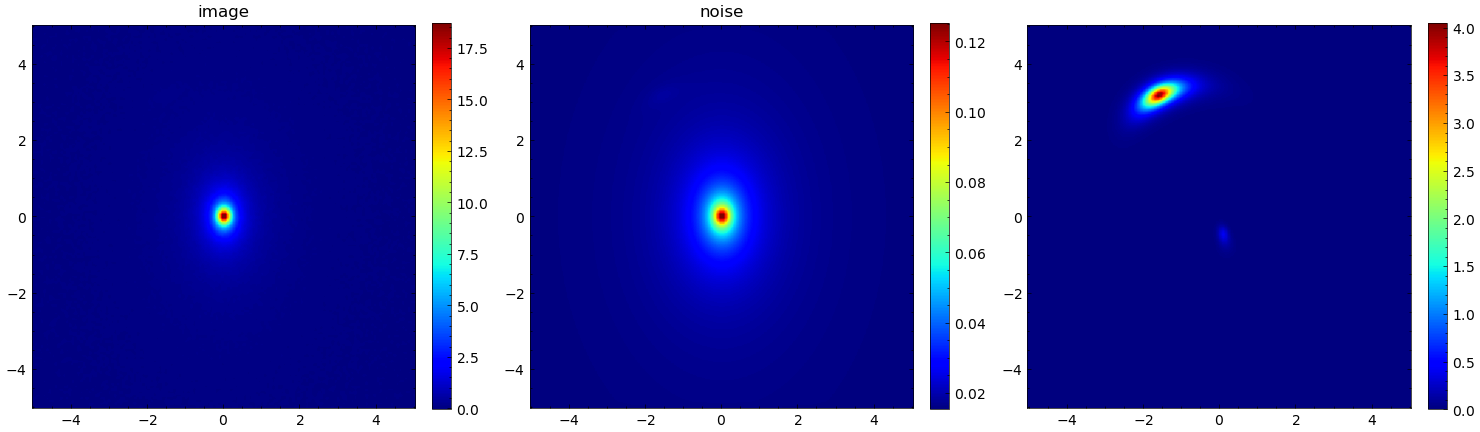

In [40]:
vis_sim_obj('stack', this_sim_obj)

9.992230120314437 2.0582768606535358


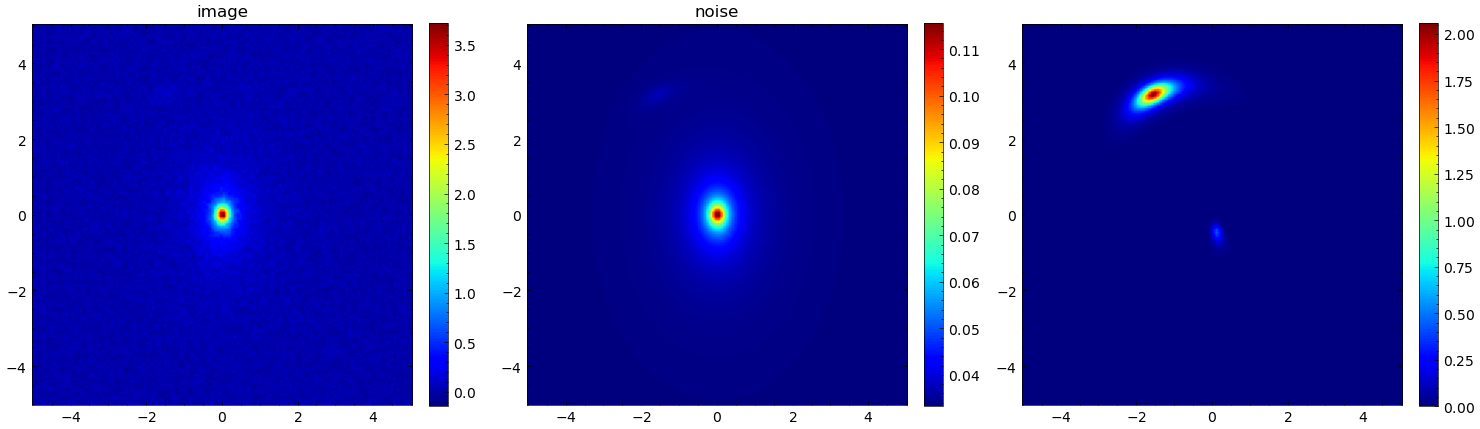

In [41]:
vis_sim_obj('g', this_sim_obj)

9.709454043996564 2.0065854808780403


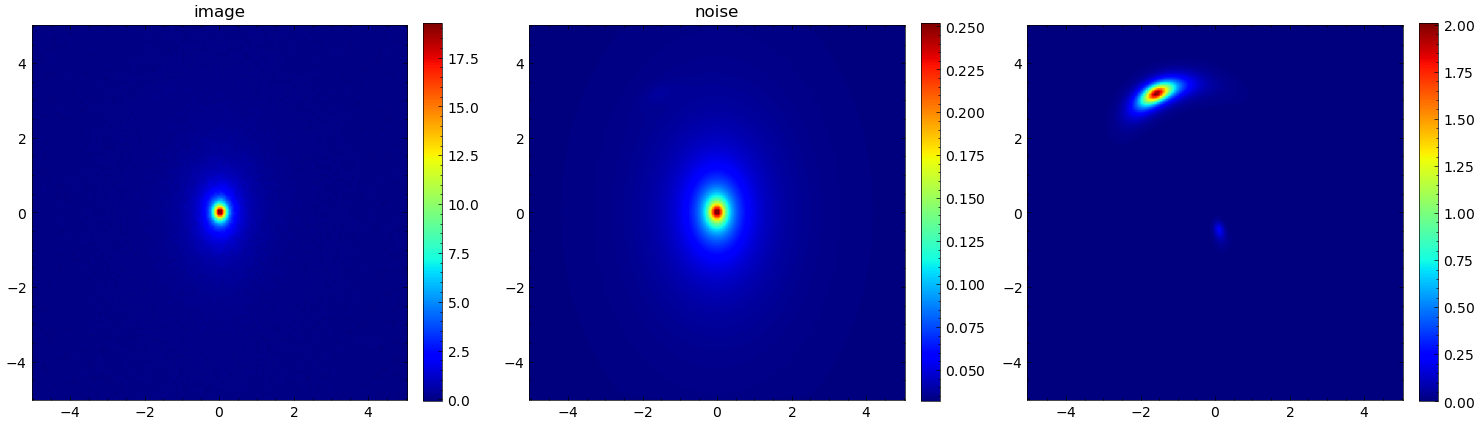

In [42]:
vis_sim_obj('r', this_sim_obj)

10.442833811567786 2.1080104101338115


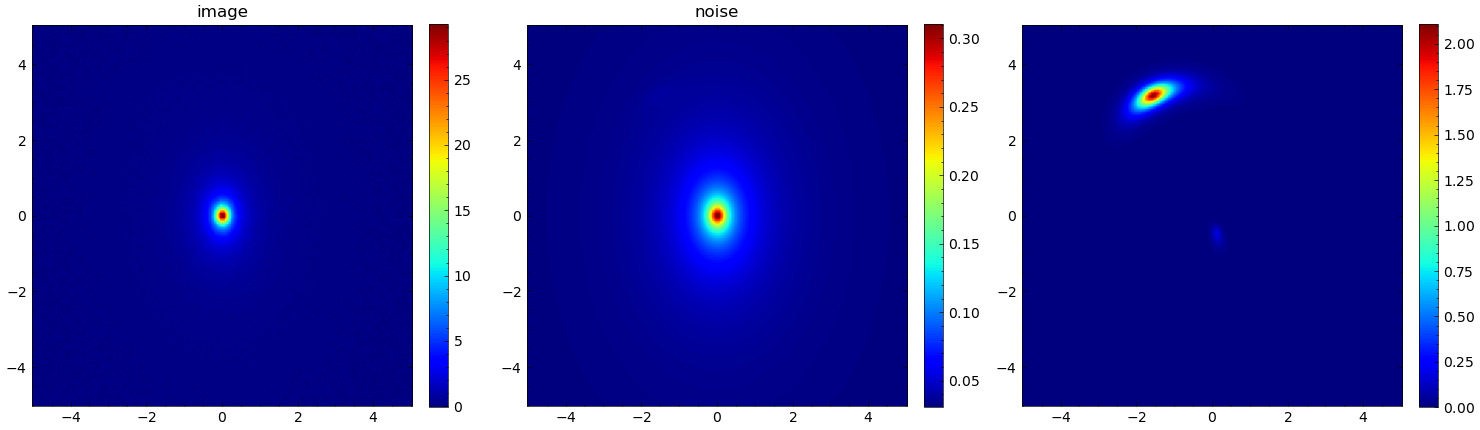

In [43]:
vis_sim_obj('i', this_sim_obj)

9.900631300498864 1.9097542755648707


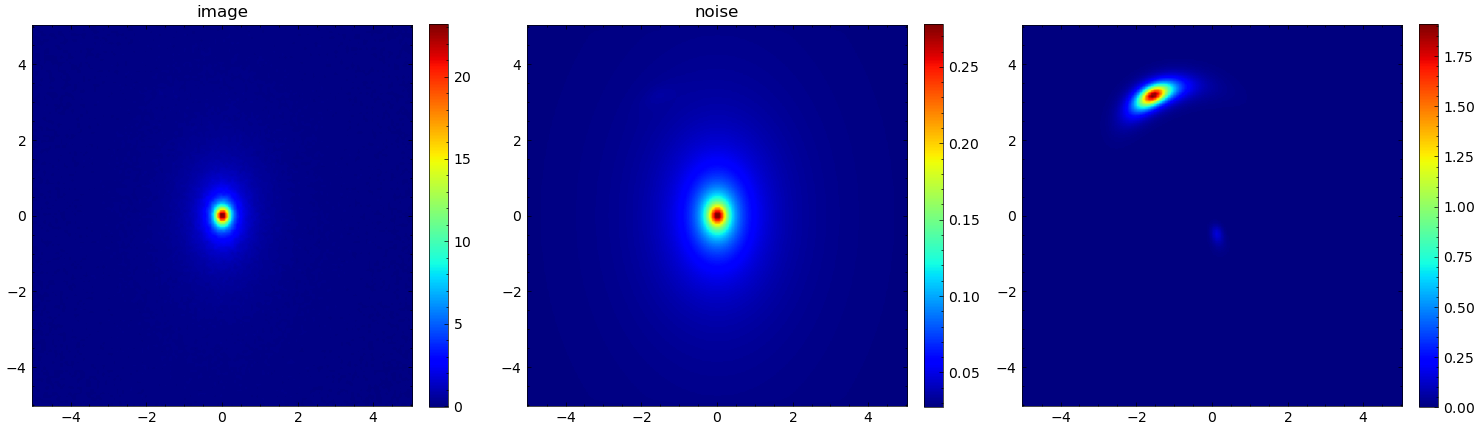

In [44]:
vis_sim_obj('z', this_sim_obj)

In [45]:
this_sn

array([[ 9.99223012,  9.70945404, 10.44283381,  9.9006313 , 20.00429489]])

In [33]:
src_id = 0
g_image = this_sim_obj[src_id]['g'].blurred_image_cps
r_image = this_sim_obj[src_id]['r'].blurred_image_cps
i_image = this_sim_obj[src_id]['i'].blurred_image_cps
tot_image = (g_image + r_image + i_image)/3.0

stack_total = this_sim_obj[src_id]['stack']['image_map_cps']
np.allclose(tot_image, stack_total)

False

<Figure size 330x250 with 0 Axes>

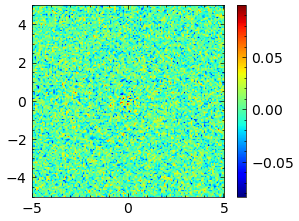

In [47]:
plt.figure()
plt.figure()
plt.imshow(
    tot_image-stack_total, 
    origin='lower', 
    cmap='jet', 
    extent=this_sim_obj[src_id]["stack"]['extent'],
)
plt.colorbar()
plt.show()

<Figure size 330x250 with 0 Axes>

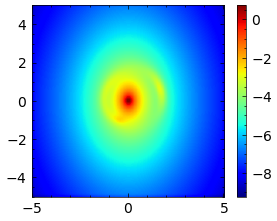

In [48]:
plt.figure()
plt.figure()
plt.imshow(
    np.log(tot_image), 
    origin='lower', 
    cmap='jet', 
    extent=this_sim_obj[src_id]["stack"]['extent'],
)
plt.colorbar()
plt.show()

/tmp/ipykernel_82535/3597773862.py:4: RuntimeWarning: invalid value encountered in log
  np.log(stack_total),


<Figure size 330x250 with 0 Axes>

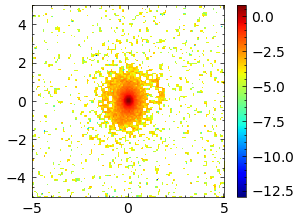

In [50]:
plt.figure()
plt.figure()
plt.imshow(
    np.log(stack_total), 
    origin='lower', 
    cmap='jet', 
    extent=this_sim_obj[src_id]["stack"]['extent'],
)
plt.colorbar()
plt.show()